### Aziz Guergachi - Javed Hakim | GHICM Model Simulations

This article has one single purpose: introduce a new and simple, yet highly insightful approach to capture, fully and quantitatively, the dynamics of the circular flow of income in economies. The proposed approach relies mostly on basic linear algebraic concepts and has deep implications for the disciplines of economics, physics and econophysics.

#### **https://doi.org/10.48550/arXiv.2307.02713**

#### *https://github.com/taimuri99/GHICM-SIMULATION-CODE/tree/main*

### Imports and Setup

In [1]:
# Imports and Setup

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix, diags
from scipy.stats import beta, pareto, truncnorm, maxwell, uniform, burr
from scipy.sparse.csgraph import connected_components
# >>> ADD SCIPY INTEGRATION FOR MEAN-FIELD CORROBORATION <<<
from scipy.integrate import odeint 
# This module contains the functions needed to solve the system's deterministic 
# average evolution (the Mean-Field Approximation).
# >>> END SCIPY INTEGRATION ADDITION <<<
import matplotlib.pyplot as plt
import gc
from typing import Tuple, List, Optional
import warnings
import psutil
from tqdm.auto import tqdm
import time
import math

# Conditional Import for GPU Acceleration
try:
    import cupy as cp
    from cupy.sparse import csr_matrix as cscsr_matrix
    GPU_AVAILABLE = cp.is_available()
except ImportError:
    print("⚠️ GPU requested but CuPy not available. Falling back to NumPy/SciPy.")
    GPU_AVAILABLE = False
    cscsr_matrix = None
    # 👇 Global Import👇
    cp = None

warnings.filterwarnings('ignore')

# Display options
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.precision', 3)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True

print("✅ All imports successful!")
print("Enhanced ICM System - Ready!")
print(f"Available RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")

⚠️ GPU requested but CuPy not available. Falling back to NumPy/SciPy.
✅ All imports successful!
Enhanced ICM System - Ready!
Available RAM: 8.0 GB


In [2]:
# Utility functions

def print_memory_usage(label=""):
    """Print current memory usage"""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / (1024 * 1024)
    available_gb = psutil.virtual_memory().available / (1024**3)
    print(f"{label} Memory usage: {memory_mb:.1f} MB | Available: {available_gb:.1f} GB")
    return memory_mb

def cleanup_memory():
    """Force garbage collection"""
    gc.collect()
    print("Memory cleaned up")
    
def format_number(num):
    """Format large numbers nicely"""
    if num >= 1e9:
        return f"{num/1e9:.1f}B"
    elif num >= 1e6:
        return f"{num/1e6:.1f}M"
    elif num >= 1e3:
        return f"{num/1e3:.1f}K"
    else:
        return str(int(num))

print("✅ Utility functions loaded!")

✅ Utility functions loaded!


### Distribution Generator

In [3]:
# Distribution Generator Class

class DistributionGenerator:
    """Generate various probability distributions for wealth modeling"""
    
    # Added xp and dtype to the signature
    def __init__(self, seed: int, xp: type = np, dtype: type = np.float64):
        self.seed = seed
        
        # =========================================================
        # Store abstraction variables
        # =========================================================
        self.xp = xp
        self.dtype = dtype
        
        # Initialize RNG: Use self.xp.random (works for both np and cp)
        self.xp.random.seed(seed)
        # Note: We rely on self.xp.random instead of a specific RandomState object (self._rng)
        # to ensure compatibility with CuPy's global RNG state.
        # =========================================================
    
    # Functions --- Changed return type hint to 'any' for xp/np compatibility
    
    def generate_boltzmann_gibbs(self, n: int, T: float = 100000, 
                                 pareto_alpha: float = 1.5, pareto_fraction: float = 0.1) -> any:
        """Boltzmann-Gibbs (exponential) with Pareto tail"""
        rate = 1 / T
        # Use self.xp.random.exponential and self.dtype
        wealth = self.xp.random.exponential(scale=1/rate, size=n).astype(self.dtype)
        
        # Add Pareto tail for specified fraction
        num_high = int(pareto_fraction * n)
        if num_high > 0:
            # Use self.xp.random.pareto and self.dtype
            pareto_wealth = self.xp.random.pareto(pareto_alpha, size=num_high).astype(self.dtype)
            wealth[:num_high] += pareto_wealth
        
        return wealth
    
    def generate_ccm(self, n: int, saving_propensity: float = 0.2, 
                     transactions: int = 50000) -> any:
        """Chakraborti-Chakrabarti Model (Note: Loop is CPU-bound)"""
        # Use self.xp.ones and self.dtype
        wealth = self.xp.ones(n, dtype=self.dtype)
        
        # CuPy's random.choice with replace=False is not always reliable.
        # This loop must be kept on the CPU side for robustness of the CCM model logic.
        # We temporarily grab the NumPy random state if self.xp is cp.
        rng_choice = np.random.RandomState(self.seed).choice if self.xp is not np else self.xp.random.choice

        for _ in range(transactions):
            i, j = rng_choice(n, 2, replace=False) 
            delta_w = (1 - saving_propensity) * (wealth[i] + wealth[j]) / 2
            wealth[i] = saving_propensity * wealth[i] + delta_w
            wealth[j] = saving_propensity * wealth[j] + delta_w
        
        # Use self.xp.random.uniform and self.xp.mean
        noise = self.xp.random.uniform(0.001, 0.01, size=n) * self.xp.mean(wealth)
        
        return wealth + noise
    
    def generate_pareto(self, n: int, alpha: float = 2.5) -> any:
        """Pareto distribution"""
        # Use self.xp.random.pareto and self.dtype
        return self.xp.random.pareto(alpha, size=n).astype(self.dtype)
    
    def generate_lognormal(self, n: int, sigma: float = 1.5, mu: float = 10) -> any:
        """Lognormal distribution"""
        # Use self.xp.log instead of np.log
        mu_log = self.xp.log(mu) - 0.5 * sigma**2
        # Use self.xp.random.lognormal and self.dtype
        return self.xp.random.lognormal(mu_log, sigma, size=n).astype(self.dtype)
    
    def generate_gamma(self, n: int, mean_target: float = 10000, shape: float = 2.0) -> any:
        """Gamma distribution"""
        scale = mean_target / shape
        # Use self.xp.random.gamma and self.dtype
        return self.xp.random.gamma(shape, scale, size=n).astype(self.dtype)
    
    
    def generate_weibull(self, n: int, shape: float = 1.5) -> any:
        """Weibull distribution"""
        # Use self.xp.random.weibull and self.dtype
        return self.xp.random.weibull(shape, size=n).astype(self.dtype)
    
    def generate_beta(self, n: int, alpha: float = 0.4, beta_param: float = 0.6) -> any:
        """Beta distribution"""
        # CRITICAL NOTE: SciPy's rvs functions do not currently support CuPy arrays.
        # This will always execute on the CPU regardless of self.xp
        return beta.rvs(alpha, beta_param, size=n, random_state=np.random.RandomState(self.seed)).astype(self.dtype)
    
    def generate_bose_einstein(self, n: int, T: float = 100000, mu: float = 0.0) -> any:
        """Bose-Einstein distribution"""
        k = 1.0
        # Use self.xp.random.uniform and self.dtype
        E = self.xp.random.uniform(0.1, 10, size=n).astype(self.dtype)
        # Use self.xp.clip, self.xp.exp, self.xp.nan_to_num
        exponent = self.xp.clip((E - mu) / (k * T), -500, 500)
        wealth = 1 / (self.xp.exp(exponent) - 1)
        return self.xp.nan_to_num(wealth, nan=1.0, posinf=1000.0, neginf=0.0)
    
    def generate_random(self, n: int) -> any:
        """Uniform random distribution"""
        # Use self.xp.random.rand and self.dtype
        return self.xp.random.rand(n).astype(self.dtype)
    
    def generate_distribution(self, n: int, model: str, **kwargs) -> any:
        """Master function to generate any distribution"""
        distribution_map = {
            'random': self.generate_random,
            'boltzgibbs': self.generate_boltzmann_gibbs,
            'gamma': self.generate_gamma,
            'lognormal': self.generate_lognormal,
            'pareto': self.generate_pareto,
            'weibull': self.generate_weibull,
            'beta': self.generate_beta,
            'ccm': self.generate_ccm,
            'bose': self.generate_bose_einstein
        }
        
        if model not in distribution_map:
            raise ValueError(f"Invalid model: {model}. Available: {list(distribution_map.keys())}")
        
        return distribution_map[model](n, **kwargs)
    
    # Changed return type hint to 'any' for xp/np compatibility
    def normalize_and_scale(self, values: any, lower_bound: float, 
                            upper_bound: float, sort_descending: bool = True) -> any:
        """Normalize to [0,1] then scale to [lower_bound, upper_bound]"""
        # Use self.xp.max and self.xp.min
        if self.xp.max(values) == self.xp.min(values):
            # Use self.xp.full_like
            return self.xp.full_like(values, (lower_bound + upper_bound) / 2)
        
        # Use self.xp.min and self.xp.max
        normalized = (values - self.xp.min(values)) / (self.xp.max(values) - self.xp.min(values))
        scaled = lower_bound + normalized * (upper_bound - lower_bound)
        
        if sort_descending:
            # Use self.xp.sort
            scaled = self.xp.sort(scaled)[::-1]
        
        return scaled

print("✅ Distribution Generator ready - supports 9 different models")

✅ Distribution Generator ready - supports 9 different models


### Enhanced Wealth Generator

In [4]:
# Enhanced Wealth Generator

class EnhancedWealthGenerator:
    """Generate initial wealth distributions using any probability model"""
    
    # Added xp and dtype to the signature
    def __init__(self, seed: int, xp: type = np, dtype: type = np.float64):
        self.xp = xp
        self.dtype = dtype
        # Pass xp and dtype to DistributionGenerator
        self.dist_gen = DistributionGenerator(seed, self.xp, self.dtype)
        self.seed = seed
        # self._rng = np.random.RandomState(seed)
    
    # Functions --- Changed return type hint to 'any' for xp/np compatibility
    
    def generate_initial_wealth(self, n_agents: int, model: str,
                                 lower_bound: float, upper_bound: float,
                                 plot: bool = False, **model_kwargs) -> any:
        """Generate initial wealth distribution"""
        
        print(f"Generating initial wealth for {format_number(n_agents)} agents using {model}")
        start_time = time.time()
        
        # Generate raw distribution
        raw_wealth = self.dist_gen.generate_distribution(n_agents, model, **model_kwargs)
        
        # Scale to desired range with wealth hierarchy (richest first)
        initial_wealth = self.dist_gen.normalize_and_scale(
            raw_wealth, lower_bound, upper_bound, sort_descending=True
        )
        
        wealth_time = time.time() - start_time
        
        # Statistics
        print(f"Completed in {wealth_time:.2f}s")
        # Use self.xp for all array statistics
        print(f"Range: ${self.xp.min(initial_wealth):,.0f} - ${self.xp.max(initial_wealth):,.0f}")
        print(f"Mean: ${self.xp.mean(initial_wealth):,.0f}")
        # Use self.xp for percentiles
        print(f"Top 1%: ${self.xp.percentile(initial_wealth, 99):,.0f}")
        print(f"Bottom 10%: ${self.xp.percentile(initial_wealth, 10):,.0f}")
        
        # Optional plotting
        if plot:
            # Convert to NumPy array for matplotlib compatibility
            if self.xp is cp:
                plot_data = initial_wealth.get()
            else:
                plot_data = initial_wealth
                
            plt.figure(figsize=(10, 6))
            plt.hist(plot_data, bins=100, density=True, alpha=0.7, color='purple')
            plt.xlabel('Wealth ($)')
            plt.ylabel('Density')
            plt.title(f'Initial Wealth Distribution ({model})')
            plt.show()
            
        print_memory_usage("After wealth generation:")
        return initial_wealth
    
    def generate_savings_fractions(self, n_agents: int, model: str, **kwargs) -> any:
        """Generate savings fractions for ICM diagonal elements"""
        raw_fractions = self.dist_gen.generate_distribution(n_agents, model, **kwargs)
        # Allow full range [0,1] for savings - column stochasticity handled elsewhere
        return self.dist_gen.normalize_and_scale(raw_fractions, 0.0, 1.0, sort_descending=True)
    
    def generate_income_fractions(self, n_agents: int, model: str, **kwargs) -> any:
        """Generate income fractions for ICM off-diagonal elements"""
        raw_income = self.dist_gen.generate_distribution(n_agents, model, **kwargs)
        # Use self.xp.abs
        # Return positive weights that will be normalized by caller
        return self.xp.abs(raw_income) + 1e-12

print("✅ Wealth Generator ready")

✅ Wealth Generator ready


### Sparse ICM Generator

In [5]:
# Sparse ICM Generator

class EnhancedSparseICM:
    """Generate and evolve sparse Income Circulation Matrices"""
    
    def __init__(self, n_agents: int, average_degree: int, 
                   chunk_size: int, seed: int, f0_seed: int,
                   # ==========================================
                   # Hardware Abstraction Parameters
                   # ==========================================
                   xp: type = np, xs: type = sparse.csr_matrix, dtype: type = np.float64):
        self.n = n_agents
        self.average_degree = average_degree # average out-degree (cohesion control)
        self.chunk_size = min(chunk_size, n_agents)
        self.seed = seed
        self.f0_seed = f0_seed
        
        # ==========================================
        # Store Hardware Abstractions
        # ==========================================
        self.xp = xp
        self.xs = xs
        self.dtype = dtype
        
        # Pass xp and dtype to EnhancedWealthGenerator
        self.wealth_gen = EnhancedWealthGenerator(f0_seed, self.xp, self.dtype)
        
        print(f"Sparse ICM initialized: {format_number(n_agents)} agents, Average degree of seperation: {average_degree} or {average_degree*n_agents} connections.") 
        
        # Use fixed average degree (k)
        self.k = average_degree
        if self.k >= self.n:
            print(f"Warning: average_degree={self.k} >= N={self.n}. Capping to N-1.")
            self.k = max(1, self.n - 1)
        
        # Total expected off-diagonal edges
        self.total_edges = self.n * self.k
        
        # Use NumPy RNG for reliable sampling (even if xp is cp)
        self._rng = np.random.RandomState(seed)
        
        print(f"Sparse ICM initialized: {format_number(n_agents)} agents, "
              f"average_degree = {average_degree} (fixed cohesion level) or Interacting Percent is {(average_degree/n_agents)*100}%")
    
    # Functions --- Changed return type hint to 'any' for xp/np compatibility
    
    def generate_sparse_F0(self, saving_model: str, income_model: str, **kwargs) -> any:
        """Generate initial sparse ICM matrix - stable vectorisation"""
        
        print(f"Generating sparse F0 with average_degree = {self.k}...")
        start_time = time.time()
        
        # 1. Generate savings fractions (diagonal)
        savings_fractions = self.wealth_gen.generate_savings_fractions(self.n, saving_model, **kwargs)
        savings_fractions = self.xp.asarray(savings_fractions, dtype=self.dtype)
        
        # Available income for spending
        spending_budget = 1.0 - savings_fractions  # Shape: (N,)
        
        # 2. Generate all off-diagonal edges at once (vectorized)
        print("Generating interaction edges (vectorized)...")
        
        # Each agent gets exactly k outgoing edges (repeat agent IDs)
        payers = np.repeat(np.arange(self.n), self.k)  # Shape: (N*k,)
        
        # Random receivers (allow self-loops temporarily, remove later)
        receivers = self._rng.randint(0, self.n, size=self.total_edges)
        
        # Remove self-loops (payer != receiver)
        mask_no_self = payers != receivers
        payers = payers[mask_no_self]
        receivers = receivers[mask_no_self]
        
        # Adjust total edges after removing self-loops (slightly less than N*k)
        actual_edges = len(payers)
        print(f"Generated {actual_edges:,} directed spending edges (after removing self-loops)")
        
        # 3. Generate raw spending weights using income model
        raw_weights = self.wealth_gen.generate_income_fractions(actual_edges, income_model, **kwargs)
        raw_weights = self.xp.asarray(raw_weights, dtype=self.dtype)
        
        # 4. Normalize weights PER COLUMN (per payer) to respect spending budget
        # First, compute total raw weight per payer (including only valid edges)
        # Use bincount for efficient per-payer sum
        raw_sums_per_payer = np.bincount(payers, weights=raw_weights.get() if self.xp is cp else raw_weights,
                                         minlength=self.n)
        raw_sums_per_payer = self.xp.asarray(raw_sums_per_payer, dtype=self.dtype)
        
        # Avoid division by zero
        raw_sums_per_payer = self.xp.clip(raw_sums_per_payer, 1e-12, None)
        
        # Scale weights so that sum per payer = spending_budget[j]
        scaling_factors = spending_budget[payers] / raw_sums_per_payer[payers]
        normalized_weights = raw_weights * scaling_factors
        
        # 5. Build sparse matrix - FORCE CPU NUMPY FOR SCIPY COMPATIBILITY
        print("Building sparse matrix...")
        
        # First: combine diagonal + off-diagonal (still on original device)
        row_indices = self.xp.concatenate([self.xp.arange(self.n), self.xp.array(receivers)])
        col_indices = self.xp.concatenate([self.xp.arange(self.n), self.xp.array(payers)])
        all_data = self.xp.concatenate([savings_fractions, normalized_weights])
        
        # Now move to CPU NumPy for SciPy sparse construction
        if self.xp is cp:
            row_indices_cpu = row_indices.get().astype(np.int64)
            col_indices_cpu = col_indices.get().astype(np.int64)
            all_data_cpu = all_data.get().astype(np.float64)
        else:
            row_indices_cpu = row_indices.astype(np.int64)
            col_indices_cpu = col_indices.astype(np.int64)
            all_data_cpu = all_data.astype(np.float64)
        
        # Construct sparse matrix with SciPy (always CSR)
        F = sparse.csr_matrix((all_data_cpu, (row_indices_cpu, col_indices_cpu)), shape=(self.n, self.n))
        
        # Final column normalization (in-place on CPU)
        col_sums = np.asarray(F.sum(axis=0)).flatten()
        col_sums = np.maximum(col_sums, 1e-12)
        
        # Scale each column's data
        for j in range(self.n):
            start = F.indptr[j]
            end = F.indptr[j + 1]
            if end > start:
                F.data[start:end] /= col_sums[j]
        
        generation_time = time.time() - start_time
        print(f"F0 completed in {generation_time:.1f}s")
        
        nnz = F.nnz
        avg_degree = (nnz / self.n) - 1
        density = nnz / (self.n * self.n)
        
        print(f"Matrix: {F.shape}, Non-zeros: {nnz:,}, "
              f"Avg degree: {avg_degree:.1f}, Density: {density:.6f}")
        
        # Accurate memory
        total_bytes = F.data.nbytes + F.indices.nbytes + F.indptr.nbytes
        total_mb = total_bytes / (1024 ** 2)
        print(f"Sparse matrix memory: ~{total_mb:.0f} MB")
        
        return F
    
    
    # >>> START MEAN-FIELD CORROBORATION IMPLEMENTATION <<<
    
    def _define_mean_field_ode(self, F_sparse: sparse.csr_matrix) -> Tuple[np.ndarray, np.ndarray]:
        """
        Derives the deterministic Mean-Field ODE system matrix A from the sparse F matrix.
        
        The ODE is dS/dt = A @ S, where A = F - I.
        This function must convert the sparse F matrix to a dense NumPy matrix 
        and then derive the transformation matrix A, which is the system's Jacobian.
        
        Since this is for CORROBORATION, we use the initial F matrix (F0) as the constant 
        Mean-Field interaction matrix, assuming minimal evolution over time.
        """
        # 1. Convert F to dense NumPy array (mandatory for ODE analysis)
        # If F is a CuPy sparse matrix, F.get() moves it to CPU/NumPy
        if self.xp is cp:
            F_cpu = F_sparse.get().get() # Convert CuPy sparse to SciPy sparse, then to dense NumPy
        elif self.xs is sparse.csr_matrix:
            F_cpu = F_sparse.toarray() # Convert SciPy sparse to dense NumPy
        else:
            # If F_sparse is already dense NumPy, use it directly
            F_cpu = F_sparse
             
        # 2. Derive the ODE Transformation Matrix A
        # The ODE is dS/dt = A * S.
        # Since S(t+1) = F * S(t) in discrete time, we have:
        # dS/dt ≈ S(t+1) - S(t) = (F - I) * S(t)
        # Thus, A = F - I (Identity Matrix)
        A_matrix = F_cpu - np.identity(self.n, dtype=self.dtype)
        
        return A_matrix
    
    def solve_mean_field(self, F_sparse: any, S0: any, T_points: np.ndarray) -> np.ndarray:
        """
        Solves the Mean-Field ODE dS/dt = A @ S using SciPy's ODE solver.
        
        Args:
            F_sparse: The initial (or static) sparse interaction matrix F0.
            S0: The initial state vector S0 (must be converted to a NumPy vector).
            T_points: A 1D NumPy array of time steps (t) to solve for.
            
        Returns:
            A 2D NumPy array containing the time evolution of the state vector S 
            according to the deterministic Mean-Field ODE.
        """
        
        # 1. Derive the dense A matrix from F0
        A_matrix = self._define_mean_field_ode(F_sparse)
        
        # 2. Define the right-hand side of the ODE (dS/dt = A @ S)
        # S_vec is the current state vector at time t
        def ode_func(S_vec, t, A_mat):
            # This is the core Mean-Field dynamic equation
            dSdt = A_mat @ S_vec
            return dSdt

        # 3. Prepare initial condition S0 (must be 1D NumPy array)
        if self.xp is cp:
            S0_cpu = S0.get()
        else:
            S0_cpu = S0
            
        # 4. Solve the ODE system
        print(f"Solving Mean-Field ODE system (N={self.n}, T={T_points[-1]}) using SciPy...")
        # odeint solves the system of ODEs
        mean_field_solution = odeint(ode_func, S0_cpu, T_points, args=(A_matrix,), tfirst=False)
        
        print("Mean-Field Solution Complete.")
        return mean_field_solution
    
    # >>> END MEAN-FIELD CORROBORATION IMPLEMENTATION <<<


    def _add_chunk_interactions(self, chunk_start, chunk_end, savings_fractions, 
                                 income_model, row_indices, col_indices, data, **kwargs):
        """Add interaction elements ensuring column stochasticity"""
        
        for j in range(chunk_start, chunk_end):
            # savings_fractions is a self.xp/cp array, force to float for subtraction
            available_income = 1.0 - float(savings_fractions[j])
            
            if available_income > 1e-12 and self.n_interactions > 0 and self.n_interactions < self.n - 1:
                # Select interacting agents (excluding self)
                # Use self.xp.arange
                available_agents = self.xp.arange(self.n)
                available_agents = available_agents[available_agents != j]
                
                n_select = min(self.n_interactions, len(available_agents))
                
                # CRITICAL: Keep self._rng.choice (NumPy) as CuPy's choice(replace=False) is buggy/complex
                # We temporarily move available_agents to CPU for choice if needed.
                if self.xp is cp:
                    available_agents_cpu = available_agents.get()
                else:
                    available_agents_cpu = available_agents
                    
                selected_agents = self._rng.choice(available_agents_cpu, n_select, replace=False)
                
                # Generate income distribution weights and normalize to available_income
                raw_weights = self.wealth_gen.generate_income_fractions(len(selected_agents), income_model, **kwargs)
                
                # Use self.xp.sum
                weight_sum = self.xp.sum(raw_weights)
                
                if weight_sum > 1e-12:
                    income_fractions = raw_weights * (available_income / weight_sum)
                else:
                    # Use self.xp.full
                    income_fractions = self.xp.full(len(selected_agents), available_income / len(selected_agents), dtype=self.dtype)
                
                # Add to sparse matrix (need to convert income_fractions and selected_agents to CPU for Python list append)
                if self.xp is cp:
                    # If CuPy array, convert to list of indices and values for append
                    selected_agents_list = selected_agents.tolist()
                    income_fractions_list = income_fractions.get().tolist()
                else:
                    # If NumPy array, convert to list of indices and values for append
                    selected_agents_list = selected_agents.tolist()
                    income_fractions_list = income_fractions.tolist()

                for i, weight in zip(selected_agents_list, income_fractions_list):
                    row_indices.append(i)
                    col_indices.append(j)
                    data.append(weight)


    def evolve_sparse_F(self, F_prev: any, a_percent: float,
                         b_percent: float, c_percent: float, ft_seed: int, step: int) -> any:
        """
        Evolve the sparse Income Circulation Matrix F(t) → F(t+1) at every time step.
        
        Scientific Logic:
        - Select a% of all agents (columns) to undergo behavioral/policy change.
        - For each selected agent, randomly perturb b% of their existing spending connections.
        - Perturbation is uniform in [-c%, +c%] of current weight.
        - Clip values to [0,1] and re-normalize column to preserve column-stochasticity
          (total outflow = 1: savings + spending).
        - This models gradual changes in trust, cohesion, policy, or economic structure.
        """
        if a_percent <= 0 or b_percent <= 0 or c_percent <= 0:
            return F_prev.copy()
        
        F = F_prev.copy()
        
        # Initialize isolated RNG for reproducibility
        rng = np.random.RandomState(ft_seed + step)
        
        # Step 1: Select a% of agents (columns) to modify
        n_cols_modify = max(1, int(a_percent * self.n / 100))
        cols_to_modify = rng.choice(self.n, size=n_cols_modify, replace=False)
        
        # Extract compressed sparse column (CSC/CSR) data for fast access
        data = F.data
        indices = F.indices
        indptr = F.indptr
        
        # Step 2: For each selected agent (column j)
        for j in cols_to_modify:
            start = indptr[j]
            end = indptr[j + 1]
            if start == end:  # no connections
                continue
                
            col_data = data[start:end]        # current spending weights to partners
            col_indices = indices[start:end]  # partner indices (not needed here)
            
            # Step 3: Select b% of this agent's connections to perturb
            n_modify = max(1, int(b_percent * len(col_data) / 100))
            modify_idx = rng.choice(len(col_data), size=n_modify, replace=False)
            
            # Step 4: Apply random perturbation ±c%
            perturbation = rng.uniform(-c_percent / 100, c_percent / 100, size=n_modify)
            col_data[modify_idx] += perturbation
            
            # Step 5: Clip to valid range [0, 1]
            col_data = np.clip(col_data, 0.0, 1.0)
            
            # Write back modified data
            data[start:end] = col_data
        
        # Step 6: Re-normalize all modified columns to maintain column-stochasticity
        # (Critical: total spending + savings = 1 per agent)
        for j in cols_to_modify:
            start = indptr[j]
            end = indptr[j + 1]
            if end > start:
                col_sum = data[start:end].sum()
                if col_sum > 1e-12:
                    data[start:end] /= col_sum
        
        return F

print("✅ Sparse ICM Generator ready with Mean-Field Approach for Large N.")

✅ Sparse ICM Generator ready with Mean-Field Approach for Large N.


### Simulation Engine

In [6]:
# Wealth Simulation Engine

class WealthSimulationEngine:
    """Memory-efficient wealth simulation with injection capabilities"""
    
    # Added xp to the signature
    def __init__(self, icm_generator: EnhancedSparseICM, xp: type = np):
        self.icm = icm_generator
        self.n = icm_generator.n
        # Store hardware abstraction
        self.xp = xp
    
    # Changed array type hint to 'any' for xp/np compatibility
    def apply_wealth_injection(self, X: any, top_percent: float,
                                 bottom_percent: float, 
                                 injection_percent: float) -> any:
        """Transfer wealth from top percentile to bottom percentile"""
        
        # Use self.xp.copy and self.icm.dtype
        X_new = X.copy().astype(self.icm.dtype)
        
        # Calculate agent counts
        # Use self.xp.ceil
        top_k = int(self.xp.ceil(top_percent / 100 * self.n))
        bottom_k = int(self.xp.ceil(bottom_percent / 100 * self.n))
        
        # Calculate total injection amount
        # Use self.xp.sum
        total_injection = self.xp.sum(X_new[:top_k]) * (injection_percent / 100)
        
        # Remove from top agents (slicing works for both np and cp)
        X_new[:top_k] *= (1 - injection_percent / 100)
        
        # Distribute equally to bottom agents
        injection_per_agent = total_injection / bottom_k
        X_new[-bottom_k:] += injection_per_agent
        
        return X_new
    
    # Changed array type hint to 'any' for xp/np compatibility
    def simulate_wealth_evolution(self, X0: any, F0: any,
                                  n_steps: int, a_percent: float, b_percent: float, 
                                  c_percent: float, ft_seed: int, injection_config: dict = None) -> tuple:
        """
        Run complete wealth simulation with optional injection and Mean-Field Corroboration.
        
        Returns: (wealth_no_injection, wealth_with_injection, mean_field_solution)
        """
        
        print(f"Starting simulation: {format_number(self.n)} agents, {n_steps} steps")
        print(f"Evolution params: a={a_percent}%, b={b_percent}%, c={c_percent}%")
        
        # Store initial state on CPU memory for the result list
        X0_cpu = X0.get() if self.xp is cp else X0
        
        # Initialise tracking
        wealth_no_injection = [X0_cpu.copy()]
        wealth_with_injection = [X0_cpu.copy()] if injection_config else None
        
        # Current states (must be on the correct device for the loop)
        X_current = X0.copy()
        X_injection_current = X0.copy() if injection_config else None
        F_current = F0
        
        start_time = time.time()

        # === MEAN-FIELD CORROBORATION SOLVER CALL ===
        # 1. Define time points for the ODE solver corresponding to the discrete steps
        T_points = np.arange(n_steps + 1)
        
        # 2. Solve the Mean-Field ODE system (dS/dt = (F0 - I)S)
        mfa_start_time = time.time()
        # The result is a 2D NumPy array: [T x N]
        mean_field_solution = self.icm.solve_mean_field(F0, X0, T_points)
        mfa_time = time.time() - mfa_start_time
        print(f"Mean-Field Solver Time: {mfa_time:.2f}s")
        # ============================================
        
        for t in tqdm(range(1, n_steps + 1), desc="Simulating"):
            # Evolve ICM matrix (except first step)
            if t > 1:
                F_current = self.icm.evolve_sparse_F(
                    F_current, a_percent, b_percent, c_percent, ft_seed, t
                )
            
            # Apply wealth injection if configured
            if injection_config and t == injection_config.get('injection_step', 20):
                print(f"Applying {injection_config['injection_percent']}% wealth injection at step {t}")
                X_injection_current = self.apply_wealth_injection(
                    X_injection_current,
                    top_percent=injection_config['top_percent'],
                    bottom_percent=injection_config['bottom_percent'], 
                    injection_percent=injection_config['injection_percent']
                )
            
            # CRITICAL MODIFICATION: Evolve wealth vectors (SpMV [Sparse Matrix-Vector Multiplication])
            # Use self.xp.asarray to convert SpMV result (sparse or dense) to a dense self.xp array
            X_current = self.xp.asarray(F_current @ X_current).flatten()
            if injection_config:
                X_injection_current = self.xp.asarray(F_current @ X_injection_current).flatten()
            
            # Store results (must move to CPU if CuPy is active)
            if self.xp is cp:
                wealth_no_injection.append(X_current.get()) # .get() moves CuPy array to NumPy/CPU
                if injection_config:
                    wealth_with_injection.append(X_injection_current.get())
            else:
                wealth_no_injection.append(X_current.copy())
                if injection_config:
                    wealth_with_injection.append(X_injection_current.copy())
            
            # Periodic memory cleanup
            if t % 20 == 0:
                gc.collect()
                # NEW ADDITION: CuPy memory cleanup
                if self.xp is cp:
                    cp.cuda.runtime.deviceSynchronize()
                    cp.get_default_memory_pool().free_all_blocks()
            
        simulation_time = time.time() - start_time
        print(f"Simulation completed in {simulation_time:.1f}s")
        print(f"Performance: {format_number(self.n * n_steps / simulation_time)} agent-steps/second")
        
        # Return the stochastic results along with the deterministic MFA result
        return wealth_no_injection, wealth_with_injection, mean_field_solution

print("✅ Simulation Engine ready with Mean-Field Approximation Integration.")

✅ Simulation Engine ready with Mean-Field Approximation Integration.


### Analysis Tools

In [7]:
# Wealth Analysis Tools

class WealthAnalyzer:
    """Analyze wealth distributions and policy impacts"""
    
    
    # Helper to ensure array is on CPU before analysis
    def _to_numpy_if_cupy(self, arr: any) -> np.ndarray:
        """Converts a CuPy array to a NumPy array, otherwise returns the array as is."""
        if 'cupy' in str(type(arr)):
            # If it's a CuPy array, move it to the CPU and return a NumPy array
            return arr.get()
        return arr
    
    
    def analyze_mean_field_solution(self, S_mfa: np.ndarray, 
                                    top_percent: float, 
                                    bottom_percent: float) -> pd.DataFrame:
        """Analyze Mean-Field ODE solution evolution over time"""
        
        results = []
        if S_mfa.ndim != 2 or S_mfa.shape[0] == 0:
            return pd.DataFrame()
            
        n = S_mfa.shape[1]
        
        for t in range(S_mfa.shape[0]):
            # Get the state vector at time t
            S = S_mfa[t, :]
            
            # CRUCIAL: Sort the deterministic solution to calculate distribution metrics (Top/Bottom)
            # The ODE solution maintains agent identity, but for distribution analysis, we must sort the wealth values.
            X_sorted = np.sort(S)[::-1] # Sort descending
            
            top_k = int(np.ceil(top_percent / 100 * n))
            bottom_k = int(np.ceil(bottom_percent / 100 * n))
            
            top_wealth = np.sum(X_sorted[:top_k])
            bottom_wealth = np.sum(X_sorted[-bottom_k:])
            total_wealth = np.sum(X_sorted)
            
            results.append({
                'step': t,
                'top_wealth': top_wealth,
                'bottom_wealth': bottom_wealth,
                'total_wealth': total_wealth,
                'top_ratio': top_wealth / total_wealth,
                'bottom_ratio': bottom_wealth / total_wealth,
                'inequality_ratio': top_wealth / bottom_wealth if bottom_wealth > 0 else np.inf,
                'gini_coefficient': self._calculate_gini(X_sorted)
            })
            
        return pd.DataFrame(results)
    
    
    def analyze_wealth_distribution(self, X_matrices: list,
                                     top_percent: float, 
                                     bottom_percent: float) -> pd.DataFrame:
        """Analyze wealth distribution evolution over time"""
        
        results = []
        
        # Guard against empty input, and ensure the first element is checked for size
        if not X_matrices:
            return pd.DataFrame()

        # Ensure the first array is NumPy to determine size N
        X_first = self._to_numpy_if_cupy(X_matrices[0])
        n = len(X_first)
        
        for t, X in enumerate(X_matrices):
            # Ensure current X is a NumPy array for all subsequent np. functions
            X = self._to_numpy_if_cupy(X)

            # Sort the stochastic result descending before analysis
            X_sorted = np.sort(X)[::-1]
            
            top_k = int(np.ceil(top_percent / 100 * n))
            bottom_k = int(np.ceil(bottom_percent / 100 * n))
            
            # All following functions (np.sum, slicing) are now safe because X is guaranteed to be NumPy
            top_wealth = np.sum(X_sorted[:top_k])
            bottom_wealth = np.sum(X_sorted[-bottom_k:])
            total_wealth = np.sum(X_sorted)
            
            results.append({
                'step': t,
                'top_wealth': top_wealth,
                'bottom_wealth': bottom_wealth,
                'total_wealth': total_wealth,
                'top_ratio': top_wealth / total_wealth,
                'bottom_ratio': bottom_wealth / total_wealth,
                'inequality_ratio': top_wealth / bottom_wealth if bottom_wealth > 0 else np.inf,
                'gini_coefficient': self._calculate_gini(X_sorted)
            })
            
        return pd.DataFrame(results)
    
    def _calculate_gini(self, wealth: any) -> float:
        """Calculate Gini coefficient for inequality measurement"""
        
        # Ensure wealth is a NumPy array before calculation
        wealth = self._to_numpy_if_cupy(wealth)
        
        if len(wealth) == 0 or np.sum(wealth) == 0:
            return 0.0
        
        sorted_wealth = np.sort(wealth)
        n = len(wealth)
        index = np.arange(1, n + 1)
        # Gini formula using NumPy for calculation
        return (2 * np.sum(index * sorted_wealth)) / (n * np.sum(sorted_wealth)) - (n + 1) / n
    
    def compare_scenarios(self, results_no_inj: pd.DataFrame, 
                              results_with_inj: pd.DataFrame) -> dict:
        """Compare scenarios with and without wealth injection"""
        
        final_no_inj = results_no_inj.iloc[-1]
        final_with_inj = results_with_inj.iloc[-1]
        
        comparison = {
            'top_wealth_reduction_pct': (final_no_inj['top_ratio'] - final_with_inj['top_ratio']) / final_no_inj['top_ratio'] * 100,
            'bottom_wealth_increase_pct': (final_with_inj['bottom_ratio'] - final_no_inj['bottom_ratio']) / final_no_inj['bottom_ratio'] * 100,
            'inequality_reduction': final_no_inj['inequality_ratio'] - final_with_inj['inequality_ratio'],
            'gini_improvement': final_no_inj['gini_coefficient'] - final_with_inj['gini_coefficient'],
            'final_top_ratio_no_inj': final_no_inj['top_ratio'],
            'final_top_ratio_with_inj': final_with_inj['top_ratio'],
            'final_bottom_ratio_no_inj': final_no_inj['bottom_ratio'],
            'final_bottom_ratio_with_inj': final_with_inj['bottom_ratio']
        }
        
        return comparison
    
    def plot_results(self, df_no_inj: pd.DataFrame, df_with_inj: pd.DataFrame,
                     df_mfa: pd.DataFrame, injection_step: int,
                     top_percent: float, bottom_percent: float,
                     X0_cpu: np.ndarray, savings_vector: np.ndarray, income_vector: np.ndarray,
                     final_wealth_no_inj: np.ndarray, final_wealth_with_inj: Optional[np.ndarray] = None,
                     average_degree: int = None):
        """Plot comprehensive wealth evolution analysis with frequency histograms"""
        has_injection = df_with_inj is not None and final_wealth_with_inj is not None
        
        fig, axes = plt.subplots(5, 2, figsize=(16, 26))
        cohesion_str = (f"Cohesion = {average_degree} avg connections"
                        if average_degree is not None else "Cohesion = N/A")
        fig.suptitle(
            f'GHICM Simulation Results\n'
            f'N = {format_number(len(X0_cpu))} agents | {cohesion_str} | Steps = {len(df_no_inj)}\n'
            f'Top {top_percent}% vs Bottom {bottom_percent}% | With Mean-Field Corroboration',
            fontsize=18, fontweight='bold', y=0.98
        )

        # Row 1: Top and Bottom Wealth Evolution
        axes[0,0].plot(df_no_inj['step'], df_no_inj['top_wealth'],
                       label='No Injection', color='teal', linewidth=2.5)
        if has_injection:
            axes[0,0].plot(df_with_inj['step'], df_with_inj['top_wealth'],
                           label='With Injection', color='orange', linewidth=2.5)
        if injection_step:
            axes[0,0].axvline(injection_step, color='red', linestyle='--', alpha=0.8, label='Injection Step')
        axes[0,0].set_title(f'Top {top_percent}% Wealth Share Over Time', fontweight='bold')
        axes[0,0].set_ylabel('Total Wealth ($)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        axes[0,1].plot(df_no_inj['step'], df_no_inj['bottom_wealth'],
                       label='No Injection', color='teal', linewidth=2.5)
        if has_injection:
            axes[0,1].plot(df_with_inj['step'], df_with_inj['bottom_wealth'],
                           label='With Injection', color='orange', linewidth=2.5)
        if injection_step:
            axes[0,1].axvline(injection_step, color='red', linestyle='--', alpha=0.8)
        axes[0,1].set_title(f'Bottom {bottom_percent}% Wealth Share Over Time', fontweight='bold')
        axes[0,1].set_ylabel('Total Wealth ($)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Row 2: Policy Impact
        if has_injection:
            steps = df_no_inj['step']
            top_change = df_with_inj['top_wealth'] - df_no_inj['top_wealth']
            bottom_change = df_with_inj['bottom_wealth'] - df_no_inj['bottom_wealth']
            axes[1,0].plot(steps, top_change, label=f'Top {top_percent}% Change', color='red', linewidth=2)
            axes[1,0].plot(steps, bottom_change, label=f'Bottom {bottom_percent}% Gain', color='green', linewidth=2)
            axes[1,0].axvline(injection_step, color='black', linestyle=':', alpha=0.7)
            axes[1,0].axhline(0, color='gray', alpha=0.5)
            axes[1,0].set_title('Wealth Transfer Due to Policy Intervention', fontweight='bold')
            axes[1,0].set_ylabel('Change in Wealth ($)')
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3)
        else:
            axes[1,0].set_visible(False)

        if has_injection:
            inequality_reduction = df_no_inj['inequality_ratio'] - df_with_inj['inequality_ratio']
            axes[1,1].plot(steps, inequality_reduction, color='purple', linewidth=2.5)
            axes[1,1].axvline(injection_step, color='black', linestyle=':', alpha=0.7)
            axes[1,1].axhline(0, color='gray', alpha=0.5)
            axes[1,1].set_title('Reduction in Inequality Ratio Due to Policy', fontweight='bold')
            axes[1,1].set_ylabel('Inequality Ratio Reduction')
            axes[1,1].legend(['Policy Effect (Inequality)'])
            axes[1,1].grid(True, alpha=0.3)
        else:
            axes[1,1].set_visible(False)

        # Row 3: Inequality Metrics
        axes[2,0].plot(df_no_inj['step'], df_no_inj['inequality_ratio'],
                       label='No Injection', color='teal', linewidth=2.5)
        if has_injection:
            axes[2,0].plot(df_with_inj['step'], df_with_inj['inequality_ratio'],
                           label='With Injection', color='orange', linewidth=2.5)
        if injection_step:
            axes[2,0].axvline(injection_step, color='red', linestyle='--', alpha=0.8)
        axes[2,0].set_title('Inequality Ratio (Top / Bottom)', fontweight='bold')
        axes[2,0].set_ylabel('Ratio')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)

        axes[2,1].plot(df_no_inj['step'], df_no_inj['gini_coefficient'],
                       label='No Injection', color='teal', linewidth=2.5)
        if has_injection:
            axes[2,1].plot(df_with_inj['step'], df_with_inj['gini_coefficient'],
                           label='With Injection', color='orange', linewidth=2.5)
        if injection_step:
            axes[2,1].axvline(injection_step, color='red', linestyle='--', alpha=0.8)
        axes[2,1].set_title('Gini Coefficient Evolution', fontweight='bold')
        axes[2,1].set_ylabel('Gini Coefficient')
        axes[2,1].legend()
        axes[2,1].grid(True, alpha=0.3)

        # Row 4: Mean-Field Corroboration
        axes[3,0].plot(df_no_inj['step'], df_no_inj['top_wealth'],
                       label='Stochastic (No Inj)', color='teal', alpha=0.8)
        axes[3,0].plot(df_mfa['step'], df_mfa['top_wealth'],
                       label='Mean-Field Approximation', color='red', linestyle='--', linewidth=3)
        axes[3,0].set_title(f'Top {top_percent}% Wealth: Stochastic vs Mean-Field', fontweight='bold')
        axes[3,0].set_ylabel('Total Wealth ($)')
        axes[3,0].legend()
        axes[3,0].grid(True, alpha=0.3)

        axes[3,1].plot(df_no_inj['step'], df_no_inj['gini_coefficient'],
                       label='Stochastic (No Inj)', color='teal', alpha=0.8)
        axes[3,1].plot(df_mfa['step'], df_mfa['gini_coefficient'],
                       label='Mean-Field Approximation', color='red', linestyle='--', linewidth=3)
        axes[3,1].set_title('Gini: Stochastic vs Mean-Field', fontweight='bold')
        axes[3,1].set_ylabel('Gini Coefficient')
        axes[3,1].legend()
        axes[3,1].grid(True, alpha=0.3)

        # --- Row 5: Final vs Initial Wealth + Fractions Frequency ---

        # Left: Initial vs Final Wealth — Probability Density with Log Scale
        ax_wealth_density = axes[4,0]
        
        # Log-spaced bins for heavy tail
        wealth_min = max(X0_cpu.min(), final_wealth_no_inj.min(), 1)  # avoid zero
        wealth_max = max(X0_cpu.max(), final_wealth_no_inj.max())
        wealth_bins = np.logspace(np.log10(wealth_min), np.log10(wealth_max), 80)
        
        ax_wealth_density.hist(X0_cpu, bins=wealth_bins, density=True, alpha=0.7,
                               label='Initial Wealth', color='#2E86AB', edgecolor='black', linewidth=0.8)
        ax_wealth_density.hist(final_wealth_no_inj, bins=wealth_bins, density=True, alpha=0.7,
                               label='Final Wealth (No Injection)', color='#A23B72', edgecolor='black', linewidth=0.8)
        if has_injection:
            ax_wealth_density.hist(final_wealth_with_inj, bins=wealth_bins, density=True, alpha=0.6,
                                   label='Final Wealth (With Injection)', color='#F18F01', edgecolor='black', linewidth=0.8)
        
        ax_wealth_density.set_xscale('log')
        ax_wealth_density.set_yscale('log')  # Optional: log-log for power-law check
        ax_wealth_density.set_title('Initial vs Final Wealth Distribution\n(Probability Density, Log-Log Scale)', fontweight='bold', fontsize=13)
        ax_wealth_density.set_xlabel('Wealth ($)')
        ax_wealth_density.set_ylabel('Probability Density')
        ax_wealth_density.grid(True, alpha=0.3, which='both')
        ax_wealth_density.legend(fontsize=10)

        # Right: Savings and Spending Fractions Frequency
        ax_frac_freq = axes[4,1]
        frac_bins = np.linspace(0, 1, 60)
        
        ax_frac_freq.hist(savings_vector, bins=frac_bins, alpha=0.7,
                          label=f'Savings Fraction\n(mean = {savings_vector.mean():.3f})',
                          color='#F18F01', edgecolor='black')
        ax_frac_freq.hist(income_vector, bins=frac_bins, alpha=0.7,
                          label=f'Spending Fraction\n(mean = {income_vector.mean():.3f})',
                          color='#C73E1D', edgecolor='black')
        
        ax_frac_freq.set_title('Savings and Spending Fractions\n(Frequency Histogram)', fontweight='bold', fontsize=13)
        ax_frac_freq.set_xlabel('Fraction (0 to 1)')
        ax_frac_freq.set_ylabel('Frequency (Count)')
        ax_frac_freq.grid(True, alpha=0.3)
        ax_frac_freq.legend(fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    
    def print_summary(self, comparison: dict, top_percent: float, bottom_percent: float):
        """Print summary of policy impact"""
        print(f"\nPOLICY IMPACT SUMMARY:")
        print(f"{'Metric':<30} {'Value':<15}")
        print("-" * 45)
        print(f"{'Top '+str(int(top_percent))+'% wealth reduction':<30} {comparison['top_wealth_reduction_pct']:.1f}%")
        print(f"{'Bottom '+str(int(bottom_percent))+'% wealth increase':<30} {comparison['bottom_wealth_increase_pct']:.1f}%") 
        print(f"{'Inequality reduction':<30} {comparison['inequality_reduction']:.2f}")
        print(f"{'Gini improvement':<30} {comparison['gini_improvement']:.4f}")
        print(f"{'Final top ratio (no inj)':<30} {comparison['final_top_ratio_no_inj']:.3f}")
        print(f"{'Final top ratio (with inj)':<30} {comparison['final_top_ratio_with_inj']:.3f}")
        print(f"{'Final bottom ratio (no inj)':<30} {comparison['final_bottom_ratio_no_inj']:.3f}")
        print(f"{'Final bottom ratio (with inj)':<30} {comparison['final_bottom_ratio_with_inj']:.3f}")

print("✅ Analysis Tools ready with Mean-Field Approximation Corroboration.")

✅ Analysis Tools ready with Mean-Field Approximation Corroboration.


### Main Enhanced ICM Class

In [8]:
# Main Enhanced ICM System

class EnhancedScalableICM:
    """
    Main class that combines all components for scalable ICM simulations
    """
    
    def __init__(self, n_agents: int, average_degree: int, chunk_size: int, seed: int, f0_seed: int,
                 # Argument to request GPU usage
                 request_gpu: bool = True): 
        
        self.n = n_agents
        self.average_degree = average_degree
        self.seed = seed
        self.f0_seed = f0_seed

        # Determine the computational environment (assuming GPU_AVAILABLE is defined globally)
        self.use_gpu = request_gpu and GPU_AVAILABLE

        if self.use_gpu:
            self.xp = cp                 # CuPy for arrays
            self.xs = cscsr_matrix       # CuPy for sparse matrices (Assuming cscsr_matrix is defined/imported)
            self.dtype = cp.float32      # Using float32 for VRAM usage
            print("🚀 Using CuPy for GPU acceleration (float32).")
        else:
            self.xp = np                 # NumPy for arrays
            self.xs = sparse.csr_matrix  # SciPy for sparse matrices
            self.dtype = np.float64      # Default to NumPy's high-precision float64
            if request_gpu:
                print("⚠️ GPU requested but CuPy not available. Falling back to NumPy/SciPy.")
            else:
                print("💻 Using NumPy/SciPy for CPU computation (float64).")

        # Initialize all components - Pass self.xp, self.xs, and self.dtype
        self.icm_generator = EnhancedSparseICM(n_agents, average_degree, chunk_size, seed, f0_seed, 
                                               xp=self.xp, xs=self.xs, dtype=self.dtype)

        # NOTE: EnhancedWealthGenerator is now typically initialized within EnhancedSparseICM, 
        # but we ensure self.wealth_gen points to the correctly initialized object.
        self.wealth_gen = self.icm_generator.wealth_gen 

        # Pass self.xp to the simulator
        self.simulator = WealthSimulationEngine(self.icm_generator, xp=self.xp)

        self.analyzer = WealthAnalyzer()

        print(f"Enhanced ICM System Ready:")
        print(f"  Agents: {format_number(n_agents)}")
        print(f"  Interaction Percent: {(average_degree/n_agents)*100}%")
        print(f"  Expected interactions per agent: {int(average_degree)}")
    
    def estimate_memory_usage(self, n_timesteps: int) -> dict:
        """Estimate memory requirements"""

        # Byte size of the chosen float type (8 for float64, 4 for float32)
        # Check self.use_gpu flag instead of referencing global 'cp' to avoid NameError.
        byte_size = 4 if self.use_gpu else 8

        # Matrix density calculation
        interaction_density = self.average_degree / self.n
        diagonal_density = 1 / self.n
        total_density = interaction_density + diagonal_density

        # Sparse matrix memory (data + indices)
        # Use byte_size for data and 8 bytes for int32 indices (4 bytes * 2)
        nnz = int(total_density * self.n * self.n)
        sparse_matrix_mb = (nnz * (byte_size + 8)) / (1024**2) 

        # Wealth vectors
        # Use byte_size
        wealth_vector_mb = (self.n * byte_size) / (1024**2)

        # Working memory (current state only)
        working_memory_mb = sparse_matrix_mb + wealth_vector_mb * 3

        return {
            'agents': format_number(self.n),
            # Report compute mode
            'compute_mode': "GPU (float32)" if self.use_gpu else "CPU (float64)",
            'density': f"{total_density:.6%}",
            'non_zero_elements': format_number(nnz),
            'sparse_matrix_mb': sparse_matrix_mb,
            'wealth_vectors_mb': wealth_vector_mb * 3,
            'working_memory_mb': working_memory_mb,
            'working_memory_gb': working_memory_mb / 1024,
            'feasible': working_memory_mb < 8000
        }
    
    
    def run_simulation(self, config) -> dict:
        """
        Run complete ICM simulation using config object
        
        Returns dictionary with all results and analysis
        """
        
        print("=" * 60)
        print("ENHANCED ICM SIMULATION")
        print("=" * 60)
        
        # Memory check
        memory_info = self.estimate_memory_usage(config.S)
        print(f"Memory estimate: {memory_info['working_memory_gb']:.2f} GB")
        
        if not memory_info['feasible']:
            print("WARNING: High memory usage expected!")
        
        results = {}
        
        # 1. Generate initial wealth
        print(f"\n1. GENERATING INITIAL WEALTH ({config.initial_wealth_model})")
        X0 = self.wealth_gen.generate_initial_wealth(
            config.n, config.initial_wealth_model, 
            config.lower_bound, config.upper_bound,
            plot=False
        )
        # Store initial wealth on CPU for reporting/plotting purposes
        X0_cpu = X0.get() if self.xp is cp else X0.copy()
        results['initial_wealth'] = X0_cpu
        
        # 2. Generate initial ICM
        print(f"\n2. GENERATING SPARSE ICM (savings: {config.saving_distribution}, income: {config.income_distribution})")
        F0 = self.icm_generator.generate_sparse_F0(config.saving_distribution, config.income_distribution)
        
        # FIXED: Store matrix info instead of full matrix for memory management
        results['matrix_info'] = {
            'shape': F0.shape,
            'nnz': F0.nnz,
            'density': F0.nnz / (F0.shape[0] * F0.shape[1])
        }
        
        # 3. Configure injection
        injection_config = {
            'injection_step': config.injection_step,
            'injection_percent': config.injection_percent,
            'top_percent': config.top_percent,
            'bottom_percent': config.bottom_percent
        }
        
        # 4. Run simulation
        print(f"\n3. RUNNING SIMULATION ({config.S} steps)")
        # CRITICAL MODIFICATION: Unpack the Mean-Field Approximation result (S_mfa)
        wealth_no_inj, wealth_with_inj, S_mfa = self.simulator.simulate_wealth_evolution(
            X0, F0, config.S, config.a, config.b, config.c, config.ft_seed, injection_config
        )
        
        # 5. Analyze results
        print("\n4. ANALYZING RESULTS")
        
        # Analyze Stochastic Simulation (No Injection)
        df_no_inj = self.analyzer.analyze_wealth_distribution(
            wealth_no_inj, config.top_percent, config.bottom_percent
        )
        results['analysis_no_injection'] = df_no_inj
        
        # Analyze Mean-Field Approximation
        print("    - Analyzing Mean-Field Approximation...")
        df_mfa = self.analyzer.analyze_mean_field_solution(
            S_mfa, config.top_percent, config.bottom_percent
        )
        results['analysis_mean_field'] = df_mfa
        
        # Analyze Stochastic Simulation (With Injection)
        if wealth_with_inj:
            df_with_inj = self.analyzer.analyze_wealth_distribution(
                wealth_with_inj, config.top_percent, config.bottom_percent
            )
            results['analysis_with_injection'] = df_with_inj
            
            # Compare scenarios
            comparison = self.analyzer.compare_scenarios(df_no_inj, df_with_inj)
            results['policy_comparison'] = comparison
            
            self.analyzer.print_summary(comparison, config.top_percent, config.bottom_percent)
        else:
            df_with_inj = None
            comparison = None
            
        # 6. Plot results
        print("\n5. GENERATING PLOTS")
        
        # Generate the savings vector used for F0 (and move to CPU)
        savings_vector = self.wealth_gen.generate_savings_fractions(
            config.n, config.saving_distribution
        )
        savings_vector_cpu = savings_vector.get() if self.xp is cp else savings_vector.copy()
        
#       # Generate the income vector used for F0 (and move to CPU)
#         income_vector = self.wealth_gen.generate_income_fractions(
#             config.n, config.income_distribution)

        # Income fractions = available spending = 1 - savings (exact from model)
        income_vector = 1.0 - savings_vector
        income_vector_cpu = income_vector.get() if self.xp is cp else income_vector.copy()
        income_vector_cpu = income_vector.get() if self.xp is cp else income_vector.copy()
        
        # === NEW: Extract final wealth states (last timestep) for the wealth pyramid plot ===
        # wealth_no_inj and wealth_with_inj are returned from simulate_wealth_evolution
        # They are usually either:
        #   - a list of wealth arrays (one per step) → take the last one
        #   - or just the final wealth array
        
        if isinstance(wealth_no_inj, list):
            final_wealth_no_inj = wealth_no_inj[-1]
        else:
            final_wealth_no_inj = wealth_no_inj
            
        if wealth_with_inj is not None:
            if isinstance(wealth_with_inj, list):
                final_wealth_with_inj = wealth_with_inj[-1]
            else:
                final_wealth_with_inj = wealth_with_inj
        else:
            final_wealth_with_inj = None
        
        # Move final wealth to CPU if on GPU
        final_wealth_no_inj_cpu = (final_wealth_no_inj.get() 
                                  if hasattr(final_wealth_no_inj, 'get') 
                                  else final_wealth_no_inj.copy())
        
        final_wealth_with_inj_cpu = None
        if final_wealth_with_inj is not None:
            final_wealth_with_inj_cpu = (final_wealth_with_inj.get() 
                                        if hasattr(final_wealth_with_inj, 'get') 
                                        else final_wealth_with_inj.copy())
        
        # === CALL THE UPDATED PLOT FUNCTION WITH FINAL WEALTH ===
        self.analyzer.plot_results(
            df_no_inj, 
            df_with_inj, 
            df_mfa,
            config.injection_step,
            config.top_percent, 
            config.bottom_percent,
            X0_cpu,                    # initial wealth
            savings_vector_cpu,        # savings fractions
            income_vector_cpu,         # income spending fractions
            final_wealth_no_inj_cpu,   # ← NEW: final wealth (no injection)
            final_wealth_with_inj_cpu, # ← NEW: final wealth (with injection, or None)
            average_degree=config.average_degree
        )
        
        # Store configuration (updated to use average_degree instead of interact_percent)
        results['configuration'] = {
            'n_agents': self.n,
            'average_degree': self.icm_generator.average_degree,
            'effective_interact_percent': (self.icm_generator.average_degree / self.n) * 100,
            'config': config.__dict__.copy(),
            'memory_info': memory_info
        }
        
        print("\n" + "=" * 60)
        print("SIMULATION COMPLETE")
        print("=" * 60)
        
        return results

print("✅ Main Enhanced ICM System ready for simulation!")

✅ Main Enhanced ICM System ready for simulation!


### SIMULATION CONFIGURATION

In [9]:
# Simulation Configuration

class SimulationConfig:
    def __init__(self):
        # Core simulation parameters
        self.average_degree = 100
        self.a = 1
        self.b = 2  
        self.c = 2
        self.n = 10000
        self.initial_wealth_model = "boltzgibbs"
        
        # Added chunk_size, required by EnhancedScalableICM
        self.chunk_size = 2048
        
        # dded missing distribution parameters
        self.saving_distribution = "random"
        self.income_distribution = "bose"
        
        # Wealth bounds
        self.lower_bound = 1000
        self.upper_bound = 100000000
        
        # Analysis parameters
        self.top_percent = 5
        self.bottom_percent = 25
        
        # PARAMETER FOR GPU USAGE
        self.use_gpu: bool = False  # Set to True to enable GPU (if available)
        
        # Random seeds
        self.seed = 8556
        self.f0_seed = 4720
        self.ft_seed = 8976
        
        # Simulation parameters
        self.S = 50
        self.injection_step = 22
        self.injection_percent = 20

print("✅ Main Simulation Configuration established!")

✅ Main Simulation Configuration established!


### SIMULATION FUNCTIONALS

In [10]:
# SIMULATION FUNCTIONALS

def run_ghicm(config):
    # Use 'config.interact_percent' and pass 'config.chunk_size' to use the value defined in the config object.
    icm_system = EnhancedScalableICM(
        n_agents=config.n,
        average_degree = config.average_degree,
        chunk_size=config.chunk_size, # Use the value from config (e.g., 2048)
        seed=config.seed,
        f0_seed=config.f0_seed,
        request_gpu=config.use_gpu # NEW: Pass the GPU request from config
    )
    
    results = icm_system.run_simulation(config)
    return results

print("✅ Simulation optimized with Configuration Settings!")

✅ Simulation optimized with Configuration Settings!


### ANALYSIS

💻 Using NumPy/SciPy for CPU computation (float64).
Sparse ICM initialized: 10.0K agents, Average degree of seperation: 100 or 1000000 connections.
Sparse ICM initialized: 10.0K agents, average_degree = 100 (fixed cohesion level) or Interacting Percent is 1.0%
Enhanced ICM System Ready:
  Agents: 10.0K
  Interaction Percent: 1.0%
  Expected interactions per agent: 100
ENHANCED ICM SIMULATION
Memory estimate: 0.02 GB

1. GENERATING INITIAL WEALTH (boltzgibbs)
Generating initial wealth for 10.0K agents using boltzgibbs
Completed in 0.00s
Range: $1,000 - $100,000,000
Mean: $11,539,032
Top 1%: $51,562,025
Bottom 10%: $1,259,565
After wealth generation: Memory usage: 152.9 MB | Available: 0.5 GB

2. GENERATING SPARSE ICM (savings: random, income: bose)
Generating sparse F0 with average_degree = 100...
Generating interaction edges (vectorized)...
Generated 999,891 directed spending edges (after removing self-loops)
Building sparse matrix...
F0 completed in 0.1s
Matrix: (10000, 10000), Non-zer

Simulating:   0%|          | 0/50 [00:00<?, ?it/s]

Applying 20% wealth injection at step 22
Simulation completed in 6.3s
Performance: 79.3K agent-steps/second

4. ANALYZING RESULTS
    - Analyzing Mean-Field Approximation...

POLICY IMPACT SUMMARY:
Metric                         Value          
---------------------------------------------
Top 5% wealth reduction        4.7%
Bottom 25% wealth increase     3.1%
Inequality reduction           0.40
Gini improvement               0.0136
Final top ratio (no inj)       0.405
Final top ratio (with inj)     0.386
Final bottom ratio (no inj)    0.076
Final bottom ratio (with inj)  0.079

5. GENERATING PLOTS


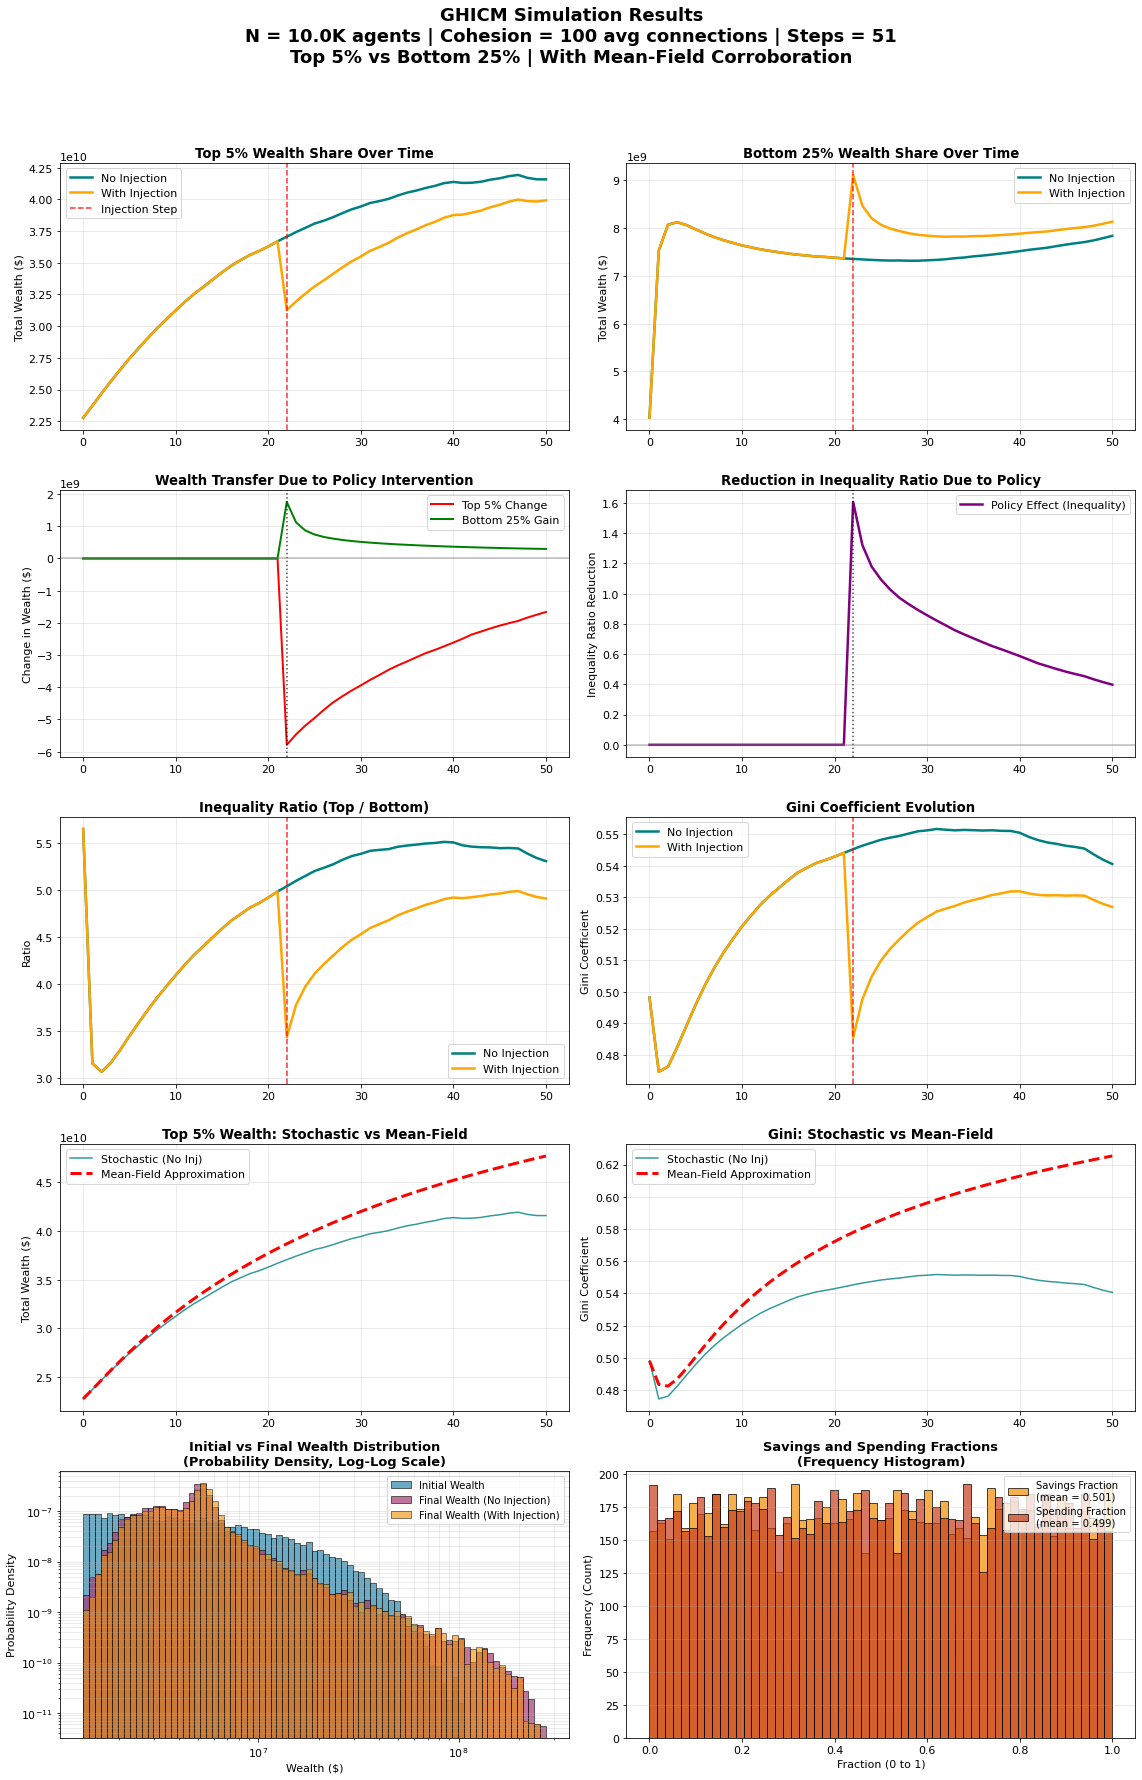


SIMULATION COMPLETE


In [11]:
# Set your parameters
config = SimulationConfig()

# Run simulation
results = run_ghicm(config)